# Implementation of k-NN Sampling for Visualization of Dynamic data using LION-tSNE

Issue with research paper algorithm:<br>
1) MNN_score is calculated after every iteration for entire dataset which is unnecessary, hence it have been changed to get optimized results<br><br>
2) Error in line: train sample = train sample ∪ X[index], should be X[train_index] <br><br>
3) Until loop is wrong in logic: (NN − score(X) = 0) ∨ (| train sample |≤ k); the second condition should be |X| <= k, as per the text in research paper -> highlighted for same. <br><br>
4) Values of t, m, s for (t,m,s)-nets were not provided in the paper

### Imports, functions & Setup

#### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# test & debug
from sklearn.datasets import load_breast_cancer

#### k nearest neighbors sampling

In [2]:
# custom function to get nn_scores, for both dynamic and static KNN-Graphs
def get_nn_scores(graph, df):
  # print(graph.shape)
  nn_scores = np.zeros(graph.shape[0], dtype=int)
  # invalid nn_scores initialize by -1
  nn_scores.fill(-1)
  # valid nn_scores initialize by 0
  for i in range(df.shape[0]):
    nn_scores[df.index[i]]=0
  for i in range(df.shape[0]):
    for j in range(graph.shape[1]):
      if nn_scores[graph[df.index[i]][j]]==-1:
        continue
      else:
        nn_scores[graph[df.index[i]][j]] += 1
  # print("get_nn_scores ran successfully")
  return nn_scores

In [3]:
# given an array a, returns a list of indices of all occurances of max_value(a) in a, empty if no elements, ignores -1 elements
def get_max_occurance_indices(a):
    if len(a) == 0:
        return []
    max_list = [0]
    max_element = a[0]
    has_valid_element = False
    for i in range(len(a)):
      if a[i]!=-1:
        # is valud
        has_valid_element = True
        max_element = a[i]
        max_list[0] = i
        break

    for i in range(1, len(a)):
      if a[i] == -1:
        continue
      elif a[i] > max_element:
        max_list = [i]
        max_element = a[i]
      elif a[i] == max_element:
        max_list.append(i)
    return max_list

In [4]:
# rather than calculating mnn_score for the entire dataset as proposed in the paper, we calculate only for the ones needed
def get_max_mnn_score_indices(graph, index):
  mnn_scores = np.zeros(len(index))

  # calculate mnn_scores of Xi for i in index
  for i in range(len(index)):
    for j in range(graph.shape[1]):
      if np.isin(index[i], graph[graph[index[i]][j]]):
        # add only to one of mutual neighbors to avoid + 2 if 2/more mutual neighbors exits in index array itself
        mnn_scores[i] += 1
  # print(mnn_scores)

  max_mnn_scores_indices = get_max_occurance_indices(mnn_scores)
  for i in range(len(max_mnn_scores_indices)):
    max_mnn_scores_indices[i] = index[max_mnn_scores_indices[i]]
  return max_mnn_scores_indices

In [5]:
# util function for algorithm
def get_row_indices_to_delete(graph, index):
  # use set to avoid repition of index
  row_indices = set()
  # add mutual neighbors
  for i in range(len(index)):
    for j in range(graph.shape[1]):
      if np.isin(index[i], graph[graph[index[i]][j]]):
        row_indices.add(graph[index[i]][j])
  # add current index elements
  for i in range(len(index)):
    row_indices.add(index[i])

  return row_indices

In [6]:
# util function for algorithm
def all_elements_zeros(nn_scores, df):
  all_zeros = True
  for i in range(df.shape[0]):
    if nn_scores[df.index[i]] != 0 and nn_scores[df.index[i]] != -1 :
      all_zeros = False
  return all_zeros

In [7]:
# util function for algorithm, uses tms-nets to select representatives from the remaining rows in the dataset
def tms_nets_selection(t, m, s, df):
    # Calculate rows per subset
    rows_per_subset = len(df) // m
    # Initialize the selected rows list
    selected_rows = []

    for i in range(m):
        if i == m - 1:
            # For the last subset, select remaining rows
            selected_rows.extend(df.sample(t - len(selected_rows)).index)
        else:
            # Select the first row randomly
            if not selected_rows:
                selected_rows.append(np.random.choice(df.index))
            while len(selected_rows) < t:
                # Calculate distances to selected rows
                distances = df.drop(selected_rows).apply(lambda row: np.min(df.iloc[selected_rows].apply(lambda x: np.linalg.norm(row - x), axis=1)), axis=1)
                # Select the row with the maximum distance while considering the minimum distance (s)
                max_dist_row = distances[distances >= s].idxmax()
                selected_rows.append(max_dist_row)

    # Get the selected rows from the DataFrame
    selected_data = df.loc[selected_rows]
    return selected_data

In [9]:
# main algorithm for the paper
# Important X must have last column as index column for proper mapping
def knn_sampling(X, k=5, dynamic_sampling=True, algorithm='auto', tms=(3, 1, 2)):
  df = X.copy()
  train_samples = pd.DataFrame(columns=df.columns[:-1])
  # k + 1 neighbors because 0th neighbor is itself, not used in knn_sampling
  knn_graph = NearestNeighbors(n_neighbors = k + 1, algorithm=algorithm).fit(df.iloc[:, :-1])
  knn_distances_matrix, knn_adjacency_matrix = knn_graph.kneighbors(df.iloc[:, :-1])

  # remove self neighbor column (col. number 0)
  knn_distances_matrix = knn_distances_matrix[:, 1:]
  knn_adjacency_matrix = knn_adjacency_matrix[:, 1:]

  # unlike the research paper, we do not calculate mnn_scores for the entire dataset to avoid redundunt space and time complexity increment, rather we use the get_max_mnn_score_indices function for the same
  # mnn_scores = np.zeros(len(knn_adjacency_matrix), dtype=int)

  while df.shape[0]>k: # other condition is written in break form
    nn_scores = get_nn_scores(knn_adjacency_matrix, df)
    if(all_elements_zeros(nn_scores, df)):
      # print("debug: all elements zeros in nn_score")
      break;
    # no need of mnn_scores of complete dataset

    # choose train_samples indices from X
    index = get_max_occurance_indices(nn_scores)
    # print("get_nn_scores ran successfully")
    train_index = list()
    if len(index) > 1:
      train_index = train_index + get_max_mnn_score_indices(knn_adjacency_matrix, index)
    else:
      train_index = train_index + index

    # append train_samples
    for i in range(len(train_index)):
      train_samples = pd.concat([train_samples, df.loc[[train_index[i]]]], ignore_index=True)

    # remove selected indices and their mutual neighbours from X
    row_to_delete = get_row_indices_to_delete(knn_adjacency_matrix, train_index)
    # sprint(row_to_delete)
    try:
      df.drop(row_to_delete, inplace=True)
    except KeyError as ke:
      print("Warning Trying to delete Key that do not exist", ke.args[0])
      df.drop(row_to_delete, inplace=True, errors='ignore')

    if df.shape[0] <= k:
      # print("debug: df shape[0] < k")
      # This is very important to avoid (0) len array exception in NearestNeighbors
      break;

    # re-create KNN-graph if needed
    if dynamic_sampling == True:
      # print("KNN-Graph-Updated")
      df.reset_index(inplace=True, drop=True)
      knn_graph = NearestNeighbors(n_neighbors = k + 1, algorithm=algorithm).fit(df.iloc[:, :-1])
      knn_distances_matrix, knn_adjacency_matrix = knn_graph.kneighbors(df.iloc[:, :-1])
      knn_distances_matrix = knn_distances_matrix[:, 1:]
      knn_adjacency_matrix = knn_adjacency_matrix[:, 1:]
    # print(train_samples)
  if df.shape[0] != 0:
    # print(df.shape[0])
    # print("Adding Left Over Rows Representatives")
    train_samples = pd.concat([train_samples, tms_nets_selection(tms[0], tms[1], tms[2], df)], ignore_index=True)
  return train_samples

In [11]:
# used for dimension reduction for visualization
def get_embeddings_BH_tNSE(df, n_components=2, init_solution='random', random_state=0, perplexity=5):
  tsne = TSNE(n_components=n_components, method='barnes_hut', init=init_solution, random_state=random_state)
  train_sample_embedded = tsne.fit_transform(df)
  return train_sample_embedded

## Testing and Debugging

#### k nearest neighbors sampling

##### Dataset 1

In [292]:
mnist = fetch_openml('mnist_784', version=1)

# Convert labels to integers
mnist.target = mnist.target.astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [293]:
X = mnist.data.iloc[:10000, :]
y = mnist.target[:10000].tolist()
X['idx'] = X.index

<ipython-input-293-8d20b5c71b0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['idx'] = X.index


In [294]:
X.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,idx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


##### Dataset 2

In [274]:
# breast_cancer = load_breast_cancer()
# X = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
# X['idx'] = X.index
# The data (569 samples with features) is in breast_cancer.data
# The target values (0 for malignant, 1 for benign) are in breast_cancer.target
# The feature names are in breast_cancer.feature_names

In [275]:
# X.drop([0], inplace=True)
# X.index[5]

##### Get Train Samples

In [295]:
train_samples = knn_sampling(X, k=10, dynamic_sampling=False)
train_samples.shape

Warning Trying to delete Key that do not exist [8941] not found in axis
Warning Trying to delete Key that do not exist [8359] not found in axis
Warning Trying to delete Key that do not exist [9841, 2813] not found in axis
Warning Trying to delete Key that do not exist [490] not found in axis
Warning Trying to delete Key that do not exist [9328, 9933, 1286, 912, 419] not found in axis
Warning Trying to delete Key that do not exist [8406, 3670, 4312] not found in axis
Warning Trying to delete Key that do not exist [8431] not found in axis
Warning Trying to delete Key that do not exist [4168, 94, 1713, 1749, 9950, 8938, 5405, 823, 9041, 1490] not found in axis
Warning Trying to delete Key that do not exist [4022, 1848, 7494, 96] not found in axis
Warning Trying to delete Key that do not exist [2082, 7838, 166, 9947, 1280, 7485] not found in axis
Warning Trying to delete Key that do not exist [8851, 3101, 3357, 7725, 9780, 2501, 9041, 3307, 4341] not found in axis
Warning Trying to delete 

(2418, 785)

In [296]:
try:
  train_samples['idx'] = train_samples['idx'].astype(int)
  train_samples_indices = train_samples['idx'].tolist()      # useful for plotting scatter graph
  train_samples.drop(columns=['idx'], inplace=True)
except KeyError as ke:
  print("Column is Already Dropped and Saved", ke.args[0])

In [297]:
train_samples.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Deminsion Reduction

In [298]:
train_sample_embeddings = get_embeddings_BH_tNSE(train_samples, n_components=2, init_solution='random', random_state=0, perplexity=5)
print(train_sample_embeddings.shape)
print(train_sample_embeddings[:, 0])

(2418, 2)
[ 54.100506   -3.6895933 -35.118214  ... -35.3737     16.77057
  20.311384 ]


#### Scatter Plot 2D

##### Scatter Plot with respect to label

In [299]:
# test if indices correctly extracted
print(train_samples_indices)

[4852, 5917, 945, 9319, 3347, 4808, 6086, 423, 4669, 6557, 6445, 5385, 98, 136, 1631, 5569, 6176, 3143, 3170, 5597, 7156, 9246, 6765, 1853, 7529, 9803, 233, 6191, 7770, 3160, 8167, 519, 4027, 5178, 6567, 8153, 8983, 8988, 2053, 5544, 4579, 3418, 3714, 4035, 4575, 5107, 7874, 4771, 9859, 505, 7, 708, 1464, 2708, 2970, 3316, 3333, 4683, 4798, 5209, 7390, 7567, 8193, 9815, 9827, 856, 3124, 6988, 8644, 9097, 1783, 153, 1847, 2139, 2615, 3003, 4571, 6635, 7089, 9229, 5471, 6054, 7527, 8846, 951, 252, 453, 1822, 2363, 2770, 4585, 6876, 7094, 7419, 7605, 8768, 8973, 9486, 471, 3009, 4371, 5341, 6642, 8263, 116, 295, 3404, 1525, 824, 2049, 2651, 3328, 4198, 4901, 6113, 6434, 6581, 8025, 8328, 9169, 4849, 6490, 6587, 5273, 157, 2657, 4450, 837, 900, 947, 987, 2415, 3264, 3625, 4026, 7693, 8145, 8180, 8858, 3153, 3581, 5708, 6020, 6124, 8121, 9194, 840, 6300, 871, 2944, 3417, 3573, 4020, 4545, 4605, 5327, 5882, 6384, 6607, 7394, 7411, 7496, 7501, 7521, 9024, 9382, 9416, 9683, 26, 1696, 1769, 277

In [300]:
labels = []
for i in train_samples_indices:
  labels.append(y[i])

In [301]:
# test if labels correctly extracted
print(labels)

[0, 8, 4, 3, 3, 3, 5, 9, 8, 5, 2, 6, 3, 3, 3, 7, 7, 0, 5, 8, 3, 2, 9, 8, 9, 1, 2, 9, 7, 0, 7, 0, 0, 7, 6, 6, 2, 5, 2, 9, 3, 1, 1, 4, 7, 1, 0, 9, 5, 7, 3, 8, 8, 1, 1, 9, 2, 6, 4, 9, 5, 2, 0, 1, 9, 3, 3, 5, 4, 7, 8, 9, 5, 8, 0, 8, 7, 6, 1, 9, 3, 7, 7, 6, 1, 2, 0, 1, 5, 0, 1, 6, 9, 5, 7, 4, 4, 6, 9, 4, 2, 9, 2, 5, 9, 8, 3, 7, 7, 5, 5, 0, 6, 9, 0, 5, 6, 2, 6, 2, 0, 4, 7, 6, 3, 6, 5, 5, 9, 5, 4, 1, 3, 4, 9, 1, 6, 1, 2, 8, 8, 1, 1, 2, 6, 0, 3, 5, 1, 0, 4, 4, 7, 7, 6, 0, 1, 1, 0, 2, 1, 1, 3, 3, 6, 7, 7, 9, 4, 1, 0, 7, 2, 4, 8, 3, 4, 1, 9, 1, 7, 6, 1, 4, 5, 4, 1, 4, 3, 9, 4, 4, 4, 0, 1, 6, 6, 7, 0, 6, 7, 5, 8, 1, 9, 2, 5, 6, 7, 1, 8, 6, 9, 2, 8, 6, 7, 6, 5, 6, 2, 3, 1, 0, 3, 8, 7, 8, 6, 8, 0, 7, 0, 5, 3, 3, 3, 8, 2, 9, 9, 1, 3, 3, 0, 9, 6, 6, 9, 9, 0, 5, 4, 0, 9, 0, 1, 7, 0, 0, 4, 0, 5, 9, 7, 9, 9, 9, 8, 0, 9, 7, 3, 6, 5, 1, 0, 2, 3, 9, 6, 4, 9, 4, 5, 9, 7, 0, 2, 5, 1, 7, 1, 2, 3, 5, 6, 4, 6, 8, 8, 8, 1, 9, 2, 7, 1, 1, 1, 1, 0, 4, 0, 3, 4, 3, 0, 2, 3, 6, 1, 4, 3, 4, 5, 6, 3, 5, 1, 1, 0, 6, 6, 

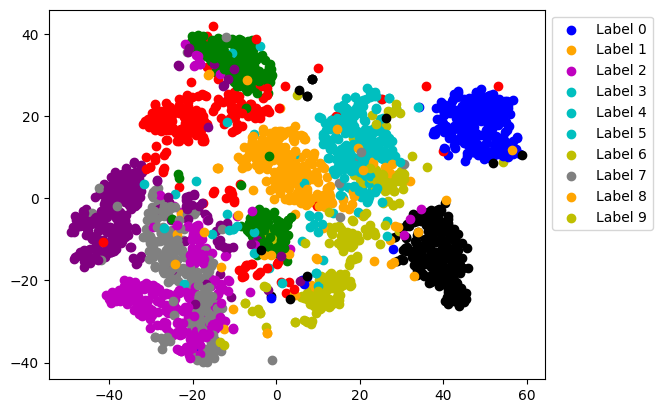

In [302]:
label_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'gray']

# Create a scatter plot with different colors for each label
for i in range(len(labels)):
    label = labels[i]
    x = train_sample_embeddings[i, 0]
    y = train_sample_embeddings[i, 1]
    plt.scatter(x, y, c=label_colors[label])

# Add a legend to the plot
plt.legend(labels=[f'Label {i}' for i in range(10)], loc='upper left', bbox_to_anchor=(1, 1))

# Show the scatter plot
plt.show()


##### Scatter Plot with K mean Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

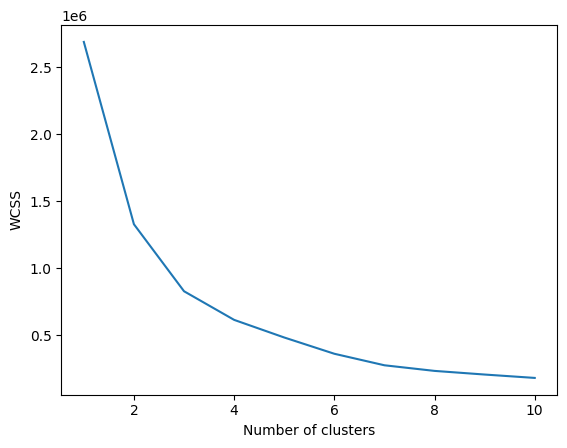

In [303]:
# Assuming train_sample_embeddings is a DataFrame or a 2D array
data = train_sample_embeddings
k_max = 11 # k for k mean clusturing
wcss = []
for i in range(1, k_max):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train_sample_embeddings)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, k_max), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [304]:
kmeans = KMeans(n_clusters = 7, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(train_sample_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [305]:
print(kmeans.cluster_centers_[:,:])
print(y_kmeans)

[[-13.199175   25.589424 ]
 [-22.304619  -25.126806 ]
 [  3.6039288 -13.11155  ]
 [ 15.674953   10.547696 ]
 [-33.70029    -4.36276  ]
 [ 37.248875  -12.85623  ]
 [ 48.0952     17.87332  ]]
[6 0 1 ... 1 2 3]


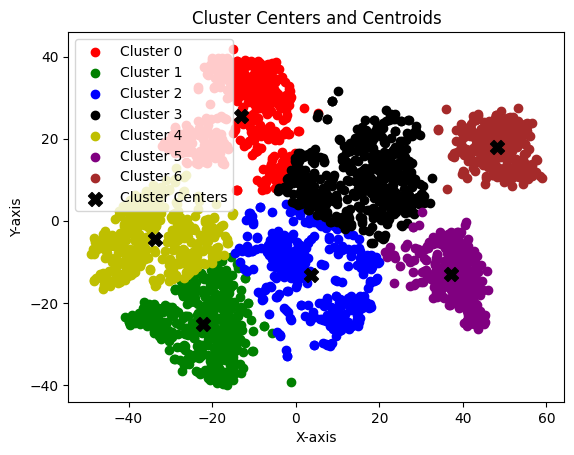

In [306]:
import numpy as np
import matplotlib.pyplot as plt

# Cluster centers and labels
centers = kmeans.cluster_centers_
labels = y_kmeans

# Set up colors for each cluster
colors = ['r', 'g', 'b', 'k', 'y', 'purple', 'brown']

# Create a scatter plot
for i in range(len(centers)):
    cluster_points = train_sample_embeddings[labels == i]  # Assuming X is your data
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i}')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='X', s=100, label='Cluster Centers')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Cluster Centers and Centroids')
plt.legend()

# Show the plot
plt.show()